# Variational Auto Encoder

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

%matplotlib inline

/Users/abulbasar/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def load_mnist_csv(path = "/data/MNIST/", one_hot = False, shape = None):
    import pandas as pd
    df_train = pd.read_csv(path + "mnist_train.csv", header=None)
    df_test = pd.read_csv(path + "mnist_test.csv", header=None)
    
    X_train = df_train.iloc[:, 1:].values/255
    X_test = df_test.iloc[:, 1:].values/255
    y_train = df_train.iloc[:, 0].values
    y_test = df_test.iloc[:, 0].values
    
    if shape == "3D":
        X_train = X_train.reshape(-1, 28, 28, 1)
        X_test = X_test.reshape(-1, 28, 28, 1)
    
    if one_hot:
        eye = np.eye(10)
        y_train, y_test = eye[y_train], eye[y_test]
        
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = load_mnist_csv(one_hot=True)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60000, 784), (10000, 784), (60000, 10), (10000, 10))

In [3]:
def data_generator(X, y = None, batch_size = 32, epochs = 1):
    from collections import namedtuple
    from math import ceil
    Batch = namedtuple("batch", ["epoch", "global_step", "progress", "X_batch", "y_batch"])
    global_step = 0
    for epoch in range(epochs):
        m = X_train.shape[0]
        indices = np.arange(m)
        np.random.shuffle(indices)
        X = X[indices]
        if not y is None:
            y = y[indices]
        num_batches = ceil(m/batch_size)
        for j in range(num_batches):
            start = j * batch_size
            end = start + batch_size
            X_batch = X[start:end]
            y_batch = None if y is None else y[start:end]
            progress = (j + 1) * 100 / num_batches
            yield Batch(epoch, global_step, progress, X_batch, y_batch)
            global_step = global_step + 1

In [4]:
def show_collage(images, nrows = 10, ncols = 10, ax = plt):
    rows = []
    for i in range(nrows):
        row = np.column_stack ([images[i * ncols + j] for j in range(ncols)])
        rows.append(row)
    collage = np.row_stack(rows)
    ax.figure(figsize = (10, 10))
    ax.imshow(collage, cmap="gray")
    ax.xticks([])
    ax.yticks([])

Hyper parameters

In [5]:
n_input = 28 * 28
n_hidden1 = 500
n_hidden2 = 100
n_hidden3 = 30
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1
n_output = n_input

learning_rate = 0.001

batch_size = 150
epochs = 10

In [6]:
tf.reset_default_graph()

learning_rate = 0.001
X = tf.placeholder(tf.float32, (None, 28, 28, 1), name='inputs')
dropout = tf.placeholder_with_default(0.0, shape=())

X_drop = tf.layers.dropout(X, rate=dropout)

### Encoder
conv1 = tf.layers.conv2d(inputs=X_drop, filters=32, kernel_size=(3,3), padding='same', activation=tf.nn.relu)
maxpool1 = tf.layers.max_pooling2d(conv1, pool_size=(2,2), strides=(2,2), padding='same')
conv2 = tf.layers.conv2d(inputs=maxpool1, filters=32, kernel_size=(3,3), padding='same', activation=tf.nn.relu)
maxpool2 = tf.layers.max_pooling2d(conv2, pool_size=(2,2), strides=(2,2), padding='same')
conv3 = tf.layers.conv2d(inputs=maxpool2, filters=16, kernel_size=(3,3), padding='same', activation=tf.nn.relu)
encoded = tf.layers.max_pooling2d(conv3, pool_size=(2,2), strides=(2,2), padding='same')

### Decoder
upsample1 = tf.image.resize_images(encoded, size=(7,7), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
conv4 = tf.layers.conv2d(inputs=upsample1, filters=16, kernel_size=(3,3), padding='same', activation=tf.nn.relu)
upsample2 = tf.image.resize_images(conv4, size=(14,14), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
conv5 = tf.layers.conv2d(inputs=upsample2, filters=32, kernel_size=(3,3), padding='same', activation=tf.nn.relu)
upsample3 = tf.image.resize_images(conv5, size=(28,28), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
conv6 = tf.layers.conv2d(inputs=upsample3, filters=32, kernel_size=(3,3), padding='same', activation=tf.nn.relu)
logits = tf.layers.conv2d(inputs=conv6, filters=1, kernel_size=(3,3), padding='same', activation=None)

# Pass logits through sigmoid to get reconstructed image
output = tf.nn.sigmoid(logits)

loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)

cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

init = tf.global_variables_initializer()

saver = tf.train.Saver()


In [7]:
print("conv1", conv1)
print("maxpool1", maxpool1)
print("conv2", conv2)
print("conv3", conv3)
print("encoded", encoded)
print("upsample1", upsample1)
print("conv4", conv4)
print("upsample2", upsample2)
print("conv5", conv5)
print("upsample3", upsample3)
print("conv6", conv6)
print("logits",logits)

conv1 Tensor("conv2d/Relu:0", shape=(?, 28, 28, 32), dtype=float32)
maxpool1 Tensor("max_pooling2d/MaxPool:0", shape=(?, 14, 14, 32), dtype=float32)
conv2 Tensor("conv2d_1/Relu:0", shape=(?, 14, 14, 32), dtype=float32)
conv3 Tensor("conv2d_2/Relu:0", shape=(?, 7, 7, 16), dtype=float32)
encoded Tensor("max_pooling2d_2/MaxPool:0", shape=(?, 4, 4, 16), dtype=float32)
upsample1 Tensor("resize_images/ResizeNearestNeighbor:0", shape=(?, 7, 7, 16), dtype=float32)
conv4 Tensor("conv2d_3/Relu:0", shape=(?, 7, 7, 16), dtype=float32)
upsample2 Tensor("resize_images_1/ResizeNearestNeighbor:0", shape=(?, 14, 14, 16), dtype=float32)
conv5 Tensor("conv2d_4/Relu:0", shape=(?, 14, 14, 32), dtype=float32)
upsample3 Tensor("resize_images_2/ResizeNearestNeighbor:0", shape=(?, 28, 28, 32), dtype=float32)
conv6 Tensor("conv2d_5/Relu:0", shape=(?, 28, 28, 32), dtype=float32)
logits Tensor("conv2d_6/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)


In [8]:
tf.set_random_seed(1)
shapes4 = []
test_img = X_train[2:3].reshape(-1, 28, 28, 1)

with tf.Session() as sess:
    sess.run(init)
    for batch in data_generator(X_train.reshape((-1, 28, 28, 1)), batch_size=batch_size, epochs=epochs):
        _, cost_, output_  = sess.run([opt, cost, output], feed_dict={X: batch.X_batch, dropout: 0.5})
        print("Epoch: %d, progress: %3d%%, loss: %.4f" % (batch.epoch, batch.progress, cost_), end="\r")
        if batch.progress == 100:
            print("")
            shapes4.append(sess.run(output, feed_dict={X: test_img})[0])
    saver.save(sess, "/tmp/tf/encoder")

Epoch: 0, progress: 100%, loss: 0.1137
Epoch: 1, progress: 100%, loss: 0.0991
Epoch: 2, progress: 100%, loss: 0.0930
Epoch: 3, progress: 100%, loss: 0.0890
Epoch: 4, progress: 100%, loss: 0.0883
Epoch: 5, progress: 100%, loss: 0.0855
Epoch: 6, progress: 100%, loss: 0.0877
Epoch: 7, progress: 100%, loss: 0.0829
Epoch: 8, progress: 100%, loss: 0.0844
Epoch: 9, progress: 100%, loss: 0.0792


In [9]:
np.array(shapes4).shape

(10, 28, 28, 1)

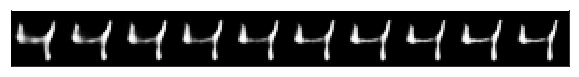

In [10]:
show_collage(np.array(shapes4).reshape(-1, 28, 28), nrows=1)

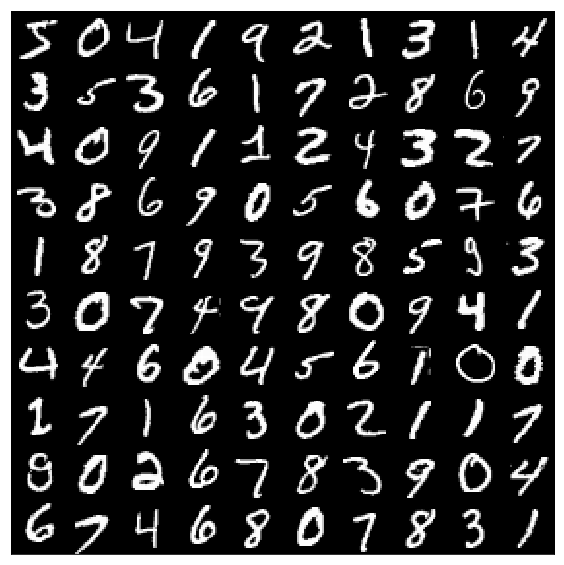

In [11]:
show_collage(X_train.reshape((-1, 28, 28))) 

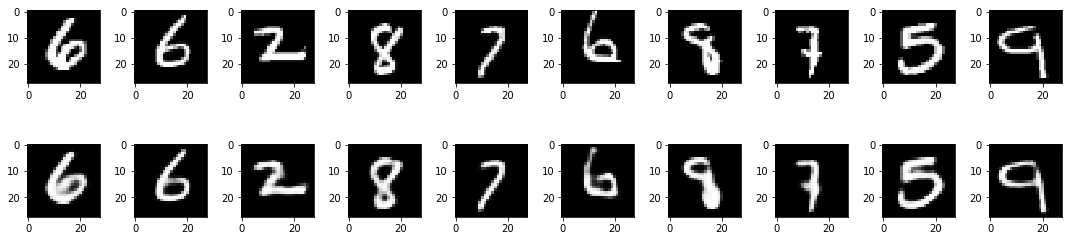

In [12]:
fig, axes = plt.subplots(2, 10, figsize = (15, 4))
for i in range(10):
    axes[0][i].imshow(batch.X_batch[i].reshape(28, 28), cmap="gray")
    axes[1][i].imshow(output_[i].reshape(28, 28), cmap="gray")
    
plt.tight_layout()

INFO:tensorflow:Restoring parameters from /tmp/tf/encoder


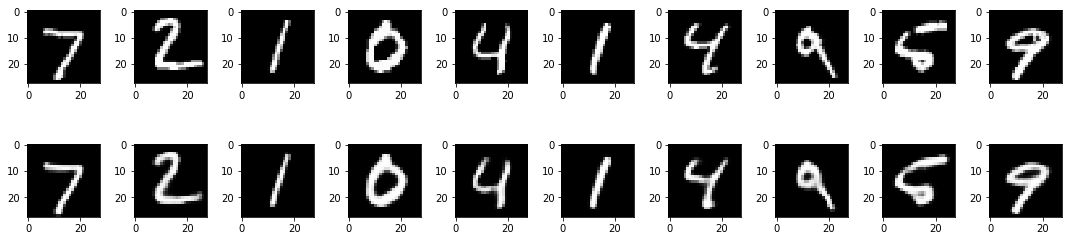

In [13]:
with tf.Session() as sess:
    saver.restore(sess, "/tmp/tf/encoder")
    output_  = sess.run(output, feed_dict={X: X_test[:20].reshape(-1, 28, 28, 1)})

fig, axes = plt.subplots(2, 10, figsize = (15, 4))
for i in range(10):
    axes[0][i].imshow(X_test[i].reshape(28, 28), cmap="gray")
    axes[1][i].imshow(output_[i].reshape(28, 28), cmap="gray")
    
plt.tight_layout()

# De-noise

INFO:tensorflow:Restoring parameters from /tmp/tf/encoder


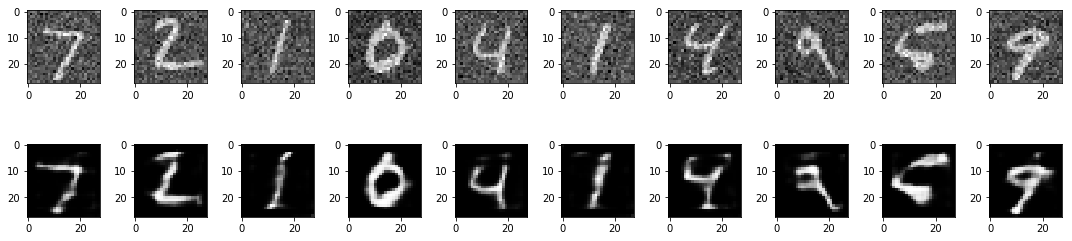

In [14]:
noisy_input = X_test[:20]
noisy_input = noisy_input + 0.2 * np.random.randn(* noisy_input.shape)

with tf.Session() as sess:
    saver.restore(sess, "/tmp/tf/encoder")
    output_  = sess.run(output, feed_dict={X: noisy_input.reshape(-1, 28, 28, 1)})

fig, axes = plt.subplots(2, 10, figsize = (15, 4))
for i in range(10):
    axes[0][i].imshow(noisy_input[i].reshape(28, 28), cmap="gray")
    axes[1][i].imshow(output_[i].reshape(28, 28), cmap="gray")
    
plt.tight_layout()